In [1]:
import numpy as np
import ctypes
#import matplotlib.pyplot as plt

import sounddevice as sd

import config 

In [2]:
def get_antenna_data():

    lib = ctypes.cdll.LoadLibrary("./lib/libsampler.so")


    init = lib.load
    init.restype = int


    get_data = lib.myread
    get_data.restype = None
    get_data.argtypes = [
        ctypes.POINTER(ctypes.c_float)
    ]

    init()

    # N_SAMPLES = 256 * 64
    # out = np.empty(N_SAMPLES, dtype=np.float32)
    # out_pointer = out.ctypes.data_as(
    #     ctypes.POINTER(ctypes.c_float))
    
    # f = lambda arr: get_data(arr.ctypes.data_as(
    #     ctypes.POINTER(ctypes.c_float)))
    
    return get_data

In [3]:
f = get_antenna_data()

signals = np.zeros(256 * 64, dtype=np.float32)

N_SAMPLES = 256 * 64
out = np.empty(N_SAMPLES, dtype=np.float32)
out_pointer = out.ctypes.data_as(
    ctypes.POINTER(ctypes.c_float))



#out2 = out.reshape((256, 64))
#
#out2[0,:]

Socket created successfully
Binding complete


In [17]:
fs = 44100
data = np.random.uniform(-1, 1, fs)
sd.play(data, fs)

In [41]:
# f(out_pointer)
# b = out.reshape((256, 64))
# 
# len(b[b != -1])

#b[:,0]
import time

dur = 2000
suu = np.zeros(256*dur, dtype=np.float32)

t = (1 / 48828) * 256 

for i in range(dur-1):
    f(out_pointer)
    b = out.reshape((256, 64))

    time.sleep(t)


    # len(b[b != -1])

    sound = b[:,1] / 2**14

    suu[i*256:(i+1)*256] = sound

    # sd.play(sound, 48828)

    # print(sound)



In [47]:
# init()


n = 32
for k in range(100):
    suu = np.zeros(256*n, dtype=np.float32)
    for i in range(n-1):
        f(out_pointer)
        b = out.reshape((256, 64))
        time.sleep(t)
        sound = b[:,1] / 2**14

        suu[i*256:(i+1)*256] = sound



    sd.play(suu, 48828)



In [8]:


N_SAMPLES = 256 * 64
out = np.empty(N_SAMPLES, dtype=np.float32)
out_pointer = out.ctypes.data_as(
    ctypes.POINTER(ctypes.c_float))


# for i in range(10):
#     get_data(out_pointer)

get_data(out_pointer)

out.shape

(16384,)

In [2]:
# Initial settings for the beamformer
N_TAPS = 256 # 16  # Defined in delay.c
N_SAMPLES = 512

directions = np.linspace(-90, 0, 91)  # Only calculate the half, and mirror the rest

exposure_samples = 512 # You can think of it like exposure time, but over frames

responses = [100, 500, 1000, 2000, 5000, 10000] #, 15000, 20000, 25000, 50000]

In [3]:
# C-Wrapper
# remember to compile the library first, issue the `make` command
lib = ctypes.cdll.LoadLibrary("./lib/libsampler.so")

calculate_coefficients = lib.py_antenna_wrapper

calculate_coefficients.restype = None
calculate_coefficients.argtypes = [
    ctypes.c_double,    # Azimuth
    ctypes.c_double,    # Elevation
    ctypes.c_int,       # Columns
    ctypes.c_int,       # Rows
    ctypes.c_float,     # Distance between elements
    ctypes.c_float,     # Samplingrate
    ctypes.c_float,     # Propagation speed
    np.ctypeslib.ndpointer(dtype=np.float32, # Coefficients
        ndim=2,
        flags='C_CONTIGUOUS'
    )
]

# # simd_delay = lib.delay_vectorized
# simd_delay = lib.delay_naive
# 
# simd_delay.restype = None
# simd_delay.argtypes = [
#     ctypes.POINTER(ctypes.c_float),
#     ctypes.POINTER(ctypes.c_float),
#     ctypes.POINTER(ctypes.c_float),
# ]

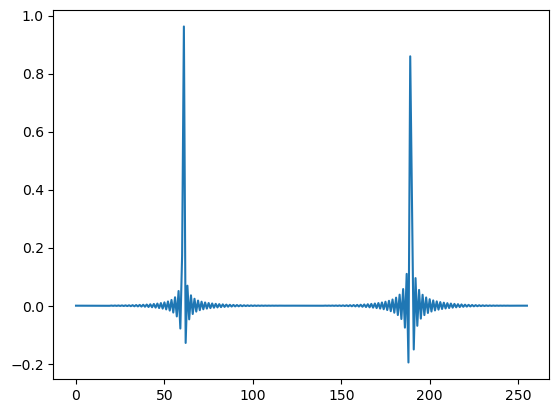

In [6]:
coefficients = np.empty((config.columns*config.rows, N_TAPS), dtype=np.float32)

azimuth = 10

calculate_coefficients(float(azimuth),
                        float(config.elevation),
                        config.columns,
                        config.rows,
                        config.distance,
                        config.fs,
                        config.propagation_speed,
                        coefficients)

coefficients

plt.plot(coefficients[4])

In [4]:
# Generate the signals but only for the half span and mirror the rest to save
# Computation.

signals = np.zeros((len(responses), 91, config.rows*config.columns, exposure_samples), dtype=np.float32)

for ihz, hz in enumerate(responses):
    print(hz)
    resolution = N_SAMPLES

    length = np.pi * 2 * hz
    signal = np.float32(np.sin(np.arange(0, length, length / resolution)))

    for k, azimuth in enumerate(directions):
        coefficients = np.empty((config.columns*config.rows, N_TAPS), dtype=np.float32)

        calculate_coefficients(float(azimuth),
                               float(config.elevation),
                               config.columns,
                               config.rows,
                               config.distance,
                               config.fs,
                               config.propagation_speed,
                               coefficients)

        for i, h in enumerate(coefficients):
            signal_pointer = signal.ctypes.data_as(
                ctypes.POINTER(ctypes.c_float))

            out = np.empty(N_SAMPLES, dtype=np.float32)
            out_pointer = out.ctypes.data_as(
                ctypes.POINTER(ctypes.c_float))

            h_pointer = h.ctypes.data_as(
                ctypes.POINTER(ctypes.c_float))
            
            simd_delay(signal_pointer, h_pointer, out_pointer)

            signals[ihz][k][i] += out[:exposure_samples]

100
500
1000
2000
5000
10000


In [40]:
# Center the array and let the signals sweep from left to right
coefficients = np.empty((config.columns*config.rows, N_TAPS), dtype=np.float32)

calculate_coefficients(0.0,
                       0.0,
                       config.columns,
                       config.rows,
                       config.distance,
                       config.fs,
                       config.propagation_speed,
                       coefficients)

out_beamformed = {}

# The beamforming process
for k in range(signals.shape[0]):
    result = []
    for i in range(signals.shape[1]):
        beamformed = np.zeros(exposure_samples, dtype=np.float32)

        for signal, h in zip(signals[k][i], coefficients):
            signal_pointer = signal.ctypes.data_as(
                ctypes.POINTER(ctypes.c_float))

            out = np.empty(N_SAMPLES, dtype=np.float32)
            out_pointer = out.ctypes.data_as(
                ctypes.POINTER(ctypes.c_float))

            h_pointer = h.ctypes.data_as(
                ctypes.POINTER(ctypes.c_float))
            
            simd_delay(signal_pointer, h_pointer, out_pointer)

            beamformed += out

        beamformed /= (config.columns*config.rows)

        power = np.sum(beamformed**2)/beamformed.size
        result.append(power)

    # Mirror the results to almost half the computation
    result.extend(result[::-1][1:])

    out_beamformed[responses[k]] = result

Text(0, 0.5, 'Amplitude')

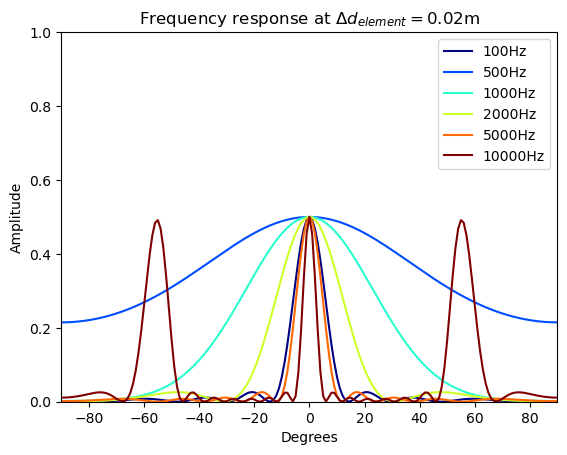

In [42]:
# Display the results of the frequency response according to the specific metri
colors = plt.cm.jet(np.linspace(0,1,len(out_beamformed)))
degrees_range = np.linspace(-90, 90, 181)

for i, (hz, response) in enumerate(zip(out_beamformed.keys(), out_beamformed.values())):
    plt.plot(degrees_range, response, color=colors[i], label="%dHz"%hz)

plt.legend()
plt.title(r"Frequency response at $\Delta d_{element}=$" + f"{config.distance}m")

plt.axis([-90, 90, 0, 1])
# plt.yscale("symlog", base=10, linthresh=0.1)
plt.xlabel("Degrees")
plt.ylabel("Amplitude")